In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

import finnhub
finnhub_client = finnhub.Client(api_key= open('finnhub_api.txt','r').read())
start = 1595988249
end = 1611852249
zoom = pd.DataFrame(finnhub_client.stock_candles('ZM', 'D', _from=start, to=end))
zoom.info()
zoom['Date'] = pd.to_datetime(zoom['t'], unit='s')
zoom.set_index('Date', inplace=True)
print(zoom.head())
print(zoom.tail())

tesla = pd.DataFrame(finnhub_client.stock_candles('TSLA', 'D', _from=start, to=end))
tesla['Date'] = pd.to_datetime(tesla['t'], unit='s')
tesla.set_index('Date', inplace=True)
print(tesla.head())
print(tesla.tail())
alphabet = pd.DataFrame(finnhub_client.stock_candles('GOOG', 'D', _from=start, to=end))
alphabet['Date'] = pd.to_datetime(alphabet['t'], unit='s')
alphabet.set_index('Date', inplace=True)
print(alphabet.head())
print(alphabet.tail())

#Earnings surprises
zoom_e = pd.DataFrame(finnhub_client.company_earnings('ZM', limit=6))
zoom_e['Period'] = pd.to_datetime(zoom_e['period'])
zoom_e.set_index('Period', inplace=True)
tesla_e = pd.DataFrame(finnhub_client.company_earnings('TSLA', limit=6))
tesla_e['Period'] = pd.to_datetime(tesla_e['period'])
tesla_e.set_index('Period', inplace=True)
alphabet_e = pd.DataFrame(finnhub_client.company_earnings('GOOG', limit=6))
alphabet_e['Period'] = pd.to_datetime(alphabet_e['period'])
alphabet_e.set_index('period', inplace=True)
print(zoom_e)
print(tesla_e)
print(alphabet_e)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c       51 non-null     float64
 1   h       51 non-null     float64
 2   l       51 non-null     float64
 3   o       51 non-null     float64
 4   s       51 non-null     object 
 5   t       51 non-null     int64  
 6   v       51 non-null     int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 2.9+ KB
                     c           h           l           o   s           t  \
Date                                                                         
2020-07-30  250.000000  256.250000  240.490005  251.589996  ok  1596067200   
2020-07-31  253.910004  255.199997  248.360107  253.500000  ok  1596153600   
2020-08-03  268.000000  271.059998  256.440002  256.440002  ok  1596412800   
2020-08-04  267.339996  268.459991  262.000000  267.350006  ok  1596499200   
2020-08-05  272.899994  275.070007 

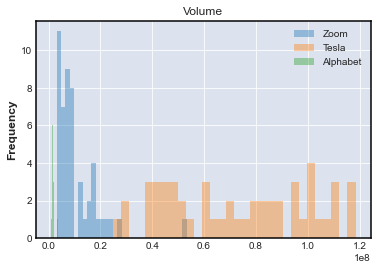

In [87]:
zoom['v'].plot.hist(bins=30, label='Zoom', title = "Volume", stacked=True, alpha=0.4)
tesla['v'].plot.hist(bins=30, label='Tesla', alpha=0.4)
alphabet['v'].plot.hist(bins=30, label='Alphabet', alpha=0.4)
plt.legend()

In [161]:
print(zoom['c'].index.max(), zoom['c'].max())
print(tesla['c'].index.max(), tesla['c'].max())
print(alphabet['c'].index.max(), alphabet['c'].max())

2020-10-09 00:00:00 500.5299987793
2020-10-09 00:00:00 498.32000732422
2020-10-09 00:00:00 1728.2800292969


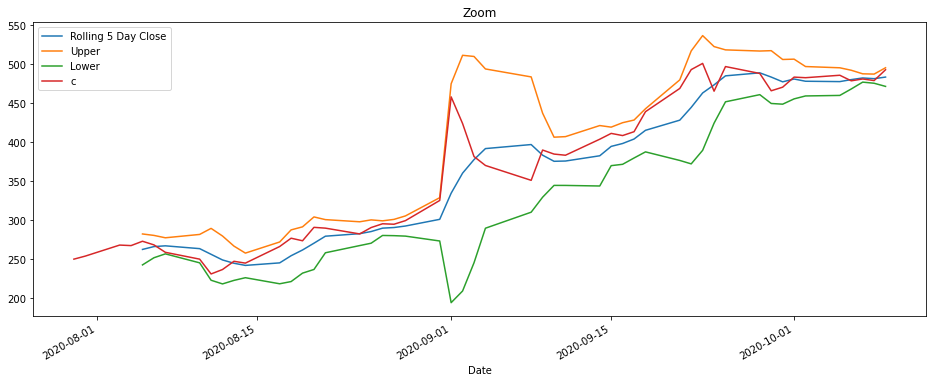

In [15]:
zoom['Rolling 5 Day Close'] = zoom['c'].rolling(window=5).mean().dropna()
stdev = zoom['c'].rolling(window=5).std().dropna()
#Upper Bollinger Band with 2stdev
zoom['Upper'] = zoom['Rolling 5 Day Close'] + 2 * stdev
#Lower Bollinger Band with 2stdev
zoom['Lower'] = zoom['Rolling 5 Day Close'] - 2 * stdev
zoom[['Rolling 5 Day Close', 'Upper', 'Lower', 'c']].plot(figsize=(16,6), title='Zoom')

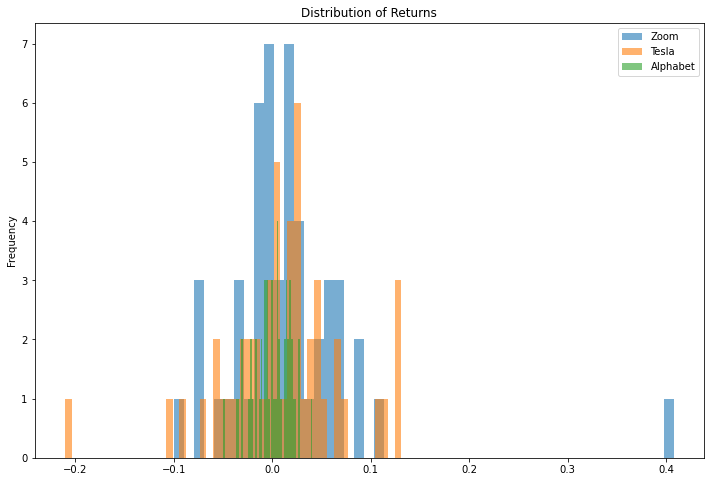

In [24]:
zoom_r = zoom['c'].pct_change(1)
tesla_r = tesla['c'].pct_change(1)
alphabet_r = alphabet['c'].pct_change(1)
zoom_r.plot.hist(bins=50, label='Zoom', figsize=(12,8), alpha=0.6, title='Distribution of Returns')
tesla_r.plot.hist(bins=50, label='Tesla', alpha=0.6)
alphabet_r.plot.hist(bins=50, label='Alphabet', alpha=0.6)
plt.legend()

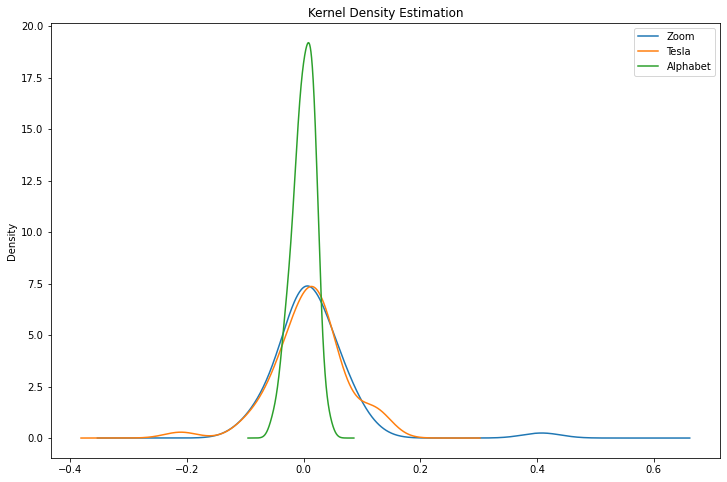

In [27]:
zoom_r.plot.kde(label='Zoom', figsize=(12,8), title='Kernel Density Estimation')
tesla_r.plot.kde(label='Tesla')
alphabet_r.plot.kde(label='Alphabet')
plt.legend()

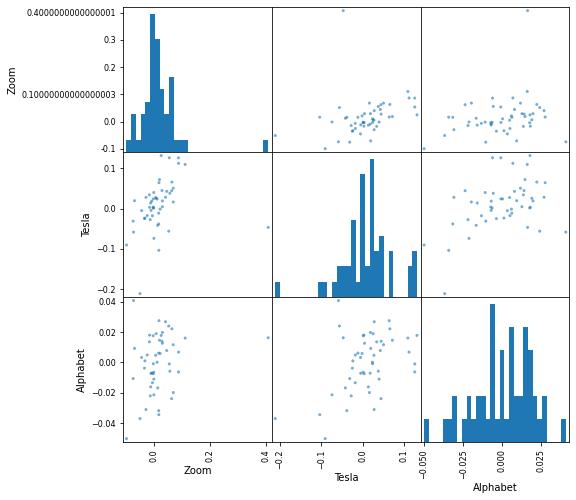

In [37]:
from pandas.plotting import scatter_matrix
comps = pd.concat([zoom_r, tesla_r, alphabet_r], axis=1)
comps.columns = ['Zoom', 'Tesla', 'Alphabet']
scatter_matrix(comps, figsize=(8,8), alpha=0.6, hist_kwds={'bins':30});

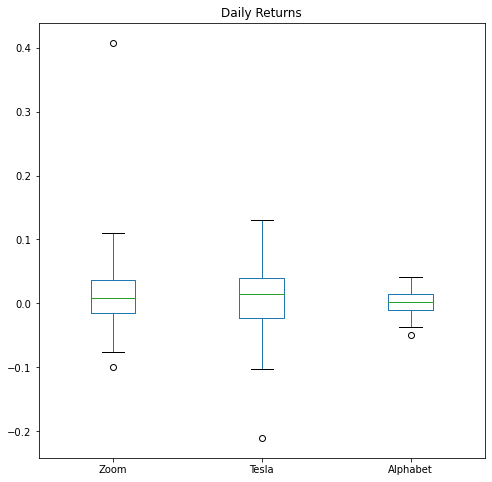

In [42]:
comps.plot.box(figsize=(8,8), title='Daily Returns')

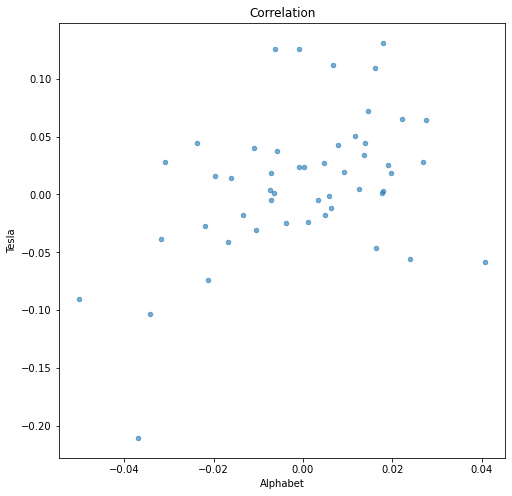

In [47]:
comps.plot.scatter(x='Alphabet', y='Tesla', alpha=0.6, figsize=(8,8), title='Correlation')

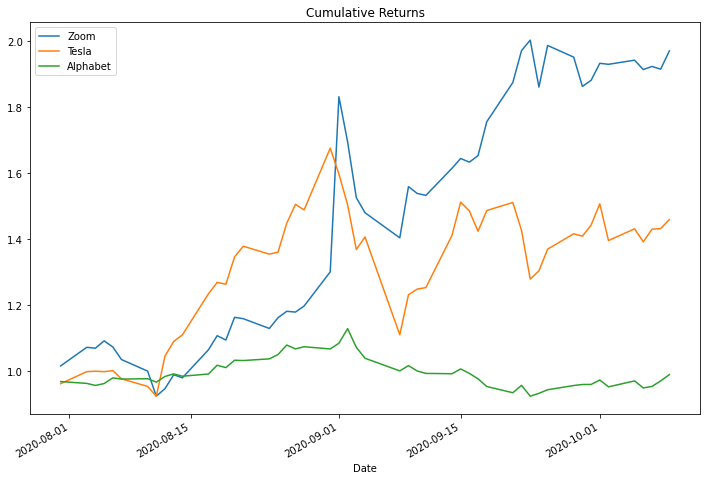

In [49]:
zoom['cum_r'] = (1 + zoom_r).cumprod()
tesla['cum_r'] = (1 + tesla_r).cumprod()
alphabet['cum_r'] = (1 + alphabet_r).cumprod()
zoom['cum_r'].plot.line(label='Zoom', figsize=(12,8), title='Cumulative Returns')
tesla['cum_r'].plot.line(label='Tesla')
alphabet['cum_r'].plot.line(label='Alphabet')
plt.legend()

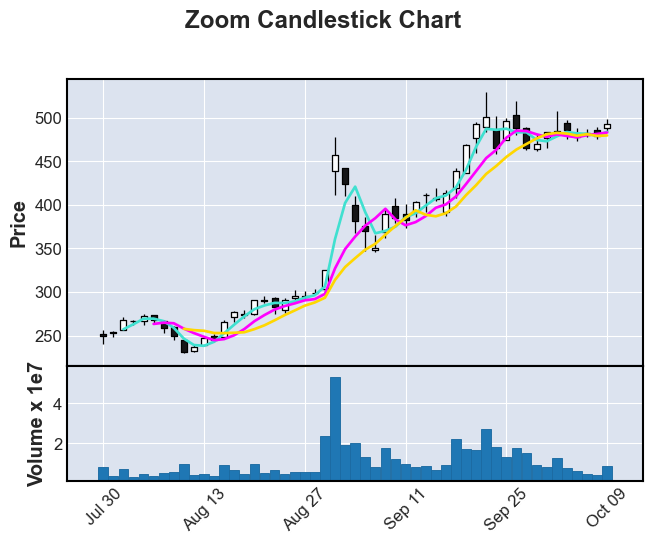

In [67]:
import mplfinance as mpf
zoom_candle = pd.DataFrame([zoom['o'], zoom['h'], zoom['l'], zoom['c'], zoom['v']]).T
zoom_candle.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
#zoom_candle.head()
#adding moving averages and volume
mpf.plot(zoom_candle, type='candle', mav=(3,6,9), volume=True, title='Zoom Candlestick Chart')

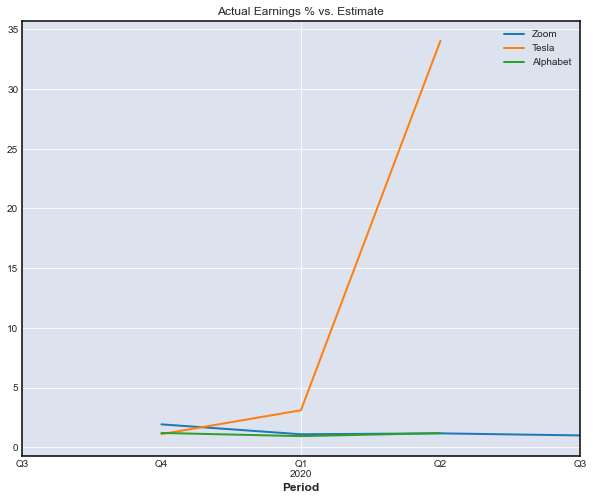

In [103]:
#zoom_e.info()
zoom_e.apply(lambda x: (zoom_e['actual'] - zoom_e['estimate'])/zoom_e['estimate'])['actual'].plot.line(label='Zoom', figsize=(10,8), title='Actual Earnings % vs. Estimate')
tesla_e.apply(lambda x: (tesla_e['actual'] - zoom_e['estimate'])/abs(tesla_e['estimate']))['actual'].plot.line(label='Tesla')
alphabet_e.apply(lambda x: (alphabet_e['actual'] - zoom_e['estimate'])/alphabet_e['estimate'])['actual'].plot.line(label='Alphabet')
plt.legend();